# Homework Assignment (Build an Automated Diagnosis Model)

Prepare the dataset images.

In [27]:
import sys
import os
import datetime

import random
import cv2
import gc

import numpy as np
import pandas as pd

# Tensorflow and Keras 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

#from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
# General methods

# Print timestamp
def timestamp():
    return 'Timestamp: %s' % datetime.datetime.now()


In [3]:
# File and dir methods

# Get directories under a given directory, ignoring some names
def get_subdirectories(path):
    filter_names = set(['__MACOSX', '.git', '.ipynb_checkpoints'])
    dirs = next(os.walk(path))[1]
    result = [d for d in dirs if d not in filter_names]
    
    return result

# Get directory listing, ignoring some files
def get_dir_filelist(path):
    filter_names = set(['.DS_Store',])
    files = os.listdir(path)
    result = [f for f in files if f not in filter_names]
    
    return result

# Select ramdomly a number of images of each class
def select_image_by_class(image_dir, image_count_per_class=1, classes=None, classes_count=None):
    if classes is None:
        classes = get_subdirectories(image_dir)
    num_classes = len(classes)
    
    if classes_count is None:
        classes_count = [image_count_per_class for c in classes]
    else:
        if len(classes_count) != len(classes):
            raise Exception('Invalid parameters', 'classes and classes_count arrays should match!')
    
    image_file_paths = {}
    
    for i in range(num_classes):
        subdir_path = image_dir + "/" + classes[i]
        subdir_files = get_dir_filelist(subdir_path)
        subdir_file_count = classes_count[i]
        subdir_file_mem = {}
        subdir_file_index = -1
        image_file_paths[classes[i]] = []

        for j in range(subdir_file_count):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
            subdir_file_mem[subdir_file_index] = 1
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path + "/" + subdir_file_name
            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths

# Count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = get_subdirectories(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(get_dir_filelist(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts

# Count number of files in single directory
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])


In [4]:
# Plotting methods

# Get plot params
def get_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    plot_params["figsize"] = figsize
    plot_params["title"] = title
    plot_params["title_fontsize"] = title_fontsize
    plot_params["legends"] = legends
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    plot_params["label_fontsize"] = label_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    plot_params["subplot"] = None
    return plot_params

# Get subplot params
def get_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    subplot_params["figsize_col"] = subplot_params["ncols"] * 2.5
    subplot_params["figsize_row"] = subplot_params["nrows"] * 2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    return subplot_params

# Get fig and axs from subplot
def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
    return fig, axs

# Plot a sample image
def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=False):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        i=i+1
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
    plt.tight_layout()
    plt.show()

# Show a sample from image classes
def show_class_sample_images(directory, image_count_per_class=5, save=False, dpi=100, update_image=False):
    class_count = len(get_subdirectories(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_class(directory, image_count_per_class)
    for class_name in sample_img_by_class:
        plot_params = get_plot_params(image_file_name="img.png", save=save, dpi=dpi, update_image=update_image)
        subplot_params = get_subplot_params(nrows=1, ncols=image_count_per_class, dpi=dpi)
        print("%s %s %s"%("-"*50, class_name, "-"*50))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s %s %d %s"%("-"*45, "All Class Printed:", class_count, "-"*45))

# Show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# Show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
# Show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])    
    title = plot_property['title']
    subplot_no = plot_property['subplot'] 
    
    
    if os.path.exists(training_dir):
        plot_property['title'] = title + " (Training)"
        count_bar_plot(training_dir, plot_property)
    
    i = 1
    if os.path.exists(validation_dir):
        plot_property['title'] = title + " (Validation)"
        plot_property['subplot'] = subplot_no + i
        count_bar_plot(validation_dir, plot_property)
        i += 1
        
    if os.path.exists(testing_dir):
        plot_property['title'] = title + " (Testing)"
        plot_property['subplot'] = subplot_no + i
        count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [5]:
# Reset tensorflow graph and free up memory
def reset(model=None):
    if model:
        try:
            del model
        except:
            return False
    
    tf.reset_default_graph()    
    # K.clear_session()
    gc.collect()
    
    return True


In [6]:
# This will only be executed if input data does not exist, to download the dataset.
if not os.path.exists('data'):
    print('Get input data.')
    os.mkdir('data')
    !wget -O ChestXRay2017.zip https://www.fenix-es.com/downloads/ml/ChestXRay2017.zip
    !unzip -d data ChestXRay2017.zip
    os.rename('data/chest_xray', 'data/input')

In [7]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = 'data/input'
output_directory = 'data/output'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

training_dir = input_directory + '/train'
validation_dir = input_directory + '/val'
testing_dir = input_directory + '/test'

# figure_directory = "data/output/figures"
# if not os.path.exists(figure_directory):
#    os.mkdir(figure_directory)

# file_name_pred_batch = figure_directory+r"/result"
# file_name_pred_sample = figure_directory+r"/sample"

In [8]:
# Prepare validation dataset. Will move half testing to validation
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
    classes, classes_count = subdirectory_file_count(testing_dir)
    classes_count = [int(c / 2) for c in classes_count]
    images = select_image_by_class(testing_dir, classes=classes, classes_count=classes_count)
    for class_name in classes:
        os.mkdir(validation_dir + '/' + class_name)
        for img_filepath in images[class_name]:
            os.rename(img_filepath, img_filepath.replace(testing_dir, validation_dir))


## Preview data

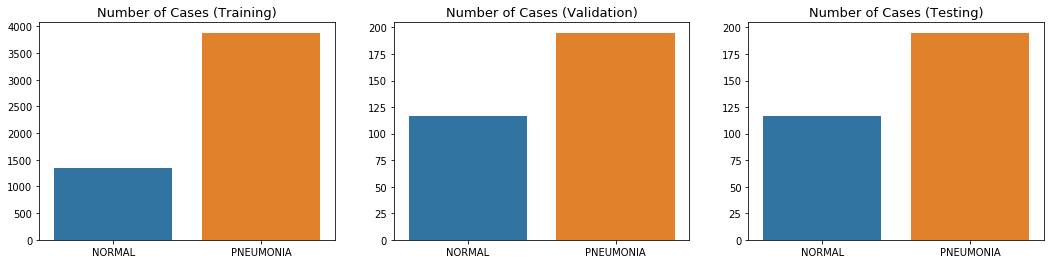

In [9]:
plot_params = get_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = get_subdirectories(training_dir)

Number of Class:  2
-------------------------------------------------- NORMAL --------------------------------------------------


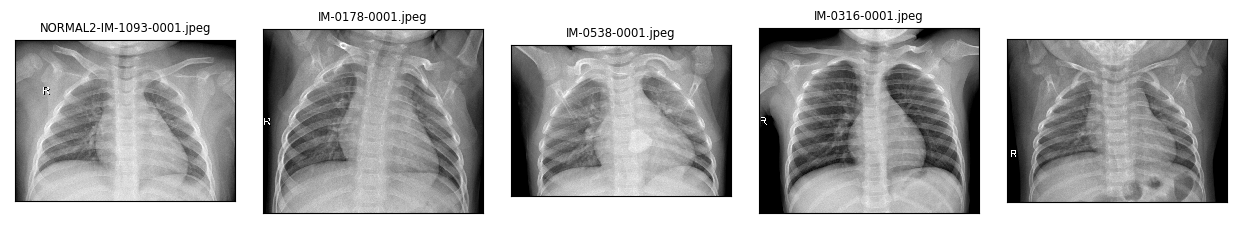


-------------------------------------------------- PNEUMONIA --------------------------------------------------


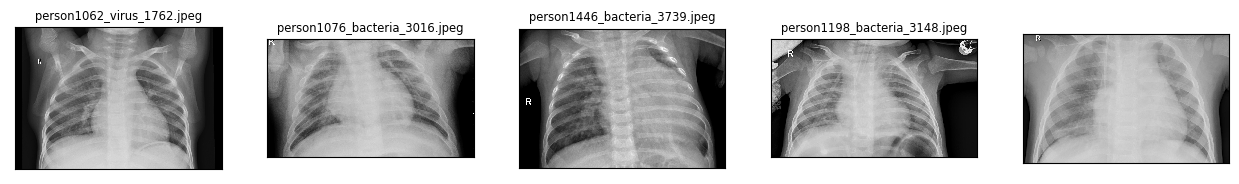


--------------------------------------------- All Class Printed: 2 ---------------------------------------------


In [10]:
show_class_sample_images(training_dir)

## Preprocessing

In [11]:
# Define image size (will be squared, so, only one dim.)
img_size = 200

rescale = 1./255
target_size = (img_size, img_size)
batch_size = 128
class_mode = "categorical"

# Rescale the Training dataset images 
train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Load the images in the generator 
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

# Rescale the validation dataset images
validation_datagen = ImageDataGenerator(rescale=rescale)

# Load the images in the generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)

# Rescale the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale)

# Load the images in the generator
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)


Found 5232 images belonging to 2 classes.
Found 312 images belonging to 2 classes.
Found 312 images belonging to 2 classes.


In [12]:
train_class_weights = class_weight.compute_class_weight(
    'balanced', 
    np.unique(train_generator.classes), 
    train_generator.classes)
print(train_class_weights)


[1.93921423 0.6737059 ]


In [13]:
# The number of classes we are trying to classify are 2
# Normal or Pneumonia
num_classes = 2
input_shape = (img_size, img_size, 3)

# Build the Model
def create_model(input_shape, num_classes, activation='sigmoid'):
    """
    Creates the image classifier model on top of a pretrained Inception v3.

    Parameters
    ----------
    input_shape: Tuple
      Shape tuple for Inception v3

    num_classes: Integer
      The number of classes that the classifier is going to classify

    activation: String
      The activation function for the prediction layer

    Returns
    -------
    The tensorflow model.  
    """
    # We start with a blank slate
    K.clear_session()

    # Inception v3 is our base model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add our custom layers on top for classification
    x = base_model.output
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # We are using the base model only for feature extraction
    # So we make sure the layer weights don't change 
    for layer in base_model.layers:
        layer.trainable = False

    # The final predictions layer is going to be a dense layer with a configurable activation
    predictions = Dense(num_classes, activation=activation)(x)
    # Instantiate the model 
    model = Model(inputs=base_model.inputs, outputs=predictions)

    return model


# Create the model with Height & Width as 230 and 3 channels for Inception
# And we are going to predict only 2 classes in our case
# We can test different activation functions
# model = create_model(input_shape, num_classes, activation='softmax')
model = create_model(input_shape, num_classes)

W0927 14:54:47.057246 140313379428224 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
# Training loss
training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
# Training Accuracy
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
# Test Loss 
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
# Test Accuracy 
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)

# Print model summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Train the model

In [15]:
print("Starting Model Trainning", timestamp())

# Set parameters
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)
optimizer = optimizers.Adam(lr=0.0001)
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 10

# Compile 
model.compile(optimizer, loss=loss, metrics=metrics)

# Start the training
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=train_class_weights,
    workers=20)

print("Model Trainning Finished", timestamp())

# Save the model
save_name = 'diagnosis_v3.hd5'
model.save(save_name)
print("Model saved:", save_name)


Starting Model Trainning Timestamp: 2019-09-27 14:54:53.771101
Epoch 1/10


W0927 14:54:57.965596 140313379428224 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


41/41 [==============================] - 395s 10s/step - loss: 0.5605 - acc: 0.7274 - val_loss: 1.1504 - val_acc: 0.6250
Epoch 2/10
41/41 [==============================] - 418s 10s/step - loss: 0.4330 - acc: 0.8012 - val_loss: 0.7999 - val_acc: 0.6122
Epoch 3/10
41/41 [==============================] - 417s 10s/step - loss: 0.3350 - acc: 0.8654 - val_loss: 1.0210 - val_acc: 0.6090
Epoch 4/10
41/41 [==============================] - 402s 10s/step - loss: 0.2968 - acc: 0.8758 - val_loss: 0.9773 - val_acc: 0.5929
Epoch 5/10
41/41 [==============================] - 424s 10s/step - loss: 0.2840 - acc: 0.8809 - val_loss: 1.4399 - val_acc: 0.6506
Epoch 6/10
41/41 [==============================] - 440s 11s/step - loss: 0.2597 - acc: 0.8995 - val_loss: 1.2852 - val_acc: 0.6442
Epoch 7/10
41/41 [==============================] - 424s 10s/step - loss: 0.2665 - acc: 0.8930 - val_loss: 0.9148 - val_acc: 0.6250
Epoch 8/10
41/41 [==============================] - 427s 10s/step - loss: 0.2476 - acc:

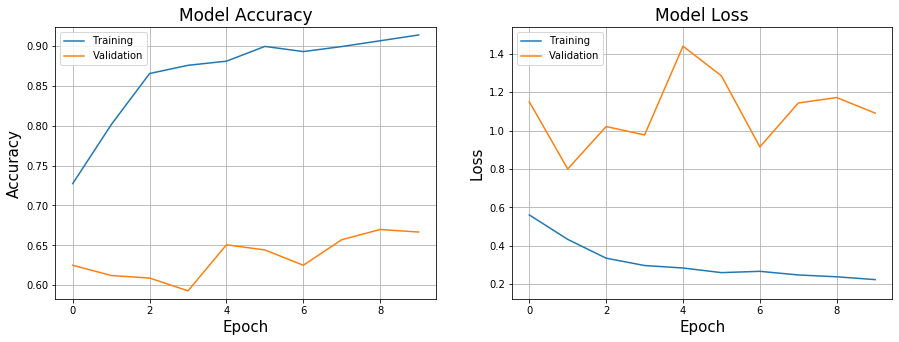

In [16]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

## Evaluate the model

In [18]:
# Load the model from file
model = tf.keras.models.load_model('diagnosis_v3.hd5')

In [19]:
# Run the model on test data
result = model.evaluate_generator(
    test_generator, 
    steps=len(test_generator),
    verbose=1)
print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 14s 14s/step - loss: 1.0785 - acc: 0.6731
Loss     : 1.08  
Accuracy : 67.31%


In [23]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

1/1 [==============================] - 12s 12s/step


In [25]:
def plot_confusion_matrix(confusion_matrix, class_names, figsize=(10,7), fontsize=14):
  """
  Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

  Parameters
  ---------
  confusion_matrix: numpy.ndarray
      The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
  class_names: list
      An ordered list of class names, in the order they index the given confusion matrix.
  figsize: tuple
      A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
      the second determining the vertical size. Defaults to (10,7).
  fontsize: int
      Font size for axes labels. Defaults to 14.
      
  Returns
  -------
  matplotlib.figure.Figure
      The resulting confusion matrix figure
  """
  cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
  fig = plt.figure(figsize=figsize)
  try:
      heatmap = sns.heatmap(cm_df, annot=True, fmt="d")
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return fig

------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 68.24%
Recall        : 89.23%
F1-Score      : 77.33%
------------------------------------------------------------------------------------------






------------------------------------------------------------------------------------------
Report for Model
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      NORMAL       0.63      0.31      0.41       117
   PNEUMONIA       0.68      0.89      0.77       195

    accuracy                           0.67       312
   macro avg       0.66      0.60      0.59       312
weighted avg       0.66      0.67      0.64       312

------------------------------------------------------------------------------------------


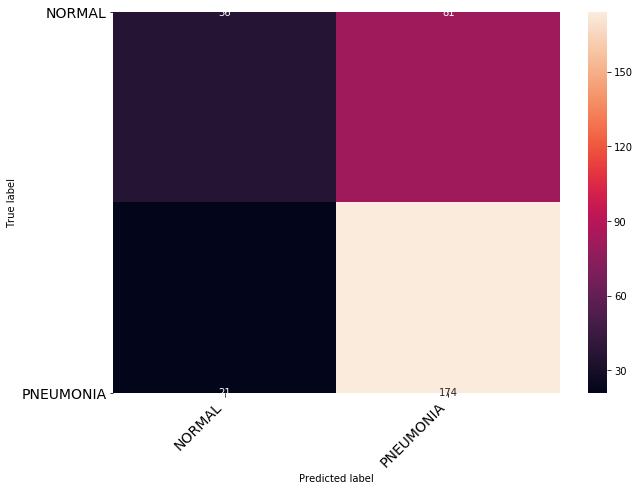

In [29]:
precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(CM, classes)

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*90)
print("Report for Model")
print("-"*90)
print(cls_report_print)
print("-"*90)